This notebook is written by the DAWS2 UQ team based in Univ. of Liverpool for the workshop of UQ & M of the DAWS2 project.

Uncertainty Quantification & Management
--
*placeholder texts*

{

Personal website: https://yuchenakaleslie.github.io/<br>
ResearchGate: https://www.researchgate.net/profile/Yu-Chen-402<br>
Contact: yu.chen2@liverpool.ac.uk

}

DAWS2 UQ team: {Scott Ferson, Ioanna,  [(Leslie) Yu Chen](https://yuchenakaleslie.github.io/)}

All rights reserved.

===================

## Table of Contents
#### [1. Setup](#Setup)
#### [2. Problem statement](#problem_statement)
#### [3. Create propagating function](#create_propagating_function)
#### [4. Epistemic uncertainty](#propagate_epistemic_uncertainty)
#### <small>[4.1. Uncertainty Characterisation](#4.1-uncertainty-characterisation)</small>
#### <small>[4.2. Uncertainty propagation methods](#4.2-uncertainty-propatation-methods)</small>
##### <small>[4.2.1. Endpoints propagation](#4.2.1-Endpoints-propatation)</small>
##### <small>[4.2.2. Subinterval reconstitution propagation](#4.2.2.-Subinterval-reconstitution-propagation)</small>
##### <small>[4.2.3. Sampling propagation](#4.2.3.-Sampling-propagation)</small>
##### <small>[4.2.4. Optimisation methods](#4.2.3.-Optimisation-methods)</small>
#### [5. Aleatory uncertainty](#aleatory_uncertainty_propagation)
#### [5. Mixed types of uncertainty](#mixed_uncertainty_propagation)

***
<a id="setup"></a>
# 1. Setup

Import the libraries

In [1]:
import numpy as np
from pyuncertainnumber.propagation.uncertaintyPropagation import Propagation, epistemic_propagation, aleatory_propagation, mixed_propagation
from pyuncertainnumber import UncertainNumber as UN
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rich

In [ ]:
# import user-defined function

USER_dir = 'C:\\Users\\Ioanna\\Documents\\GitHub\pyuncertainnumber_new\\cantilever_beam'
import sys
sys.path.append(USER_dir)

***
<a id="problem_statement"></a>
# 2. Problem statement

The numerical example models a simple cantilever beam with length, $L$, distance to the neutral axis $y$, Young’s modulus, $E$, second moment of inertia, $I$, and external load, $F$. We will compute the bending stress $σ$, and the deflection $d$, assuming the above input parameters are **uncertain numbers**.

We will use this example throughout the document to illustrate the differences among various uncertainty quantification approaches. A complete description of the following methods can be found in the [DAWS1 report](https://sites.google.com/view/dawsreports/up).

![alt text](../assets/cantilever.png)

**Fig.1** Cantilever beam with input parameters.  

***
<a id="create_propagating_function"></a>
# 3. Create the propagating function


A propagating function is created which calculates the deflection, $d$, as a function of $L$, $E$, $I$, and $F$.
- The function's input is only the uncertain numbers.
- As sampling techniques are used it is likely that for a certain input combination the airfoil will fail to reach a solution. we use the try function to accomodate for this.


Alternatively, such propating function can be imported as a Python function/method object from a certain local directory.

<a id="3.1.-create-function"></a>

## 3.1. Create propagating function

In [3]:
def cantilever_beam_deflection(x):
    """Calculates deflection and stress for a cantilever beam.

    Args:
        x (np.array): Array of input parameters:
            x[0]: Length of the beam (m)
            x[1]: Second moment of area (mm^4)
            x[2]: Applied force (N)
            x[3]: Young's modulus (MPa)

    Returns:
        float: deflection (m)
               Returns np.nan if calculation error occurs.
    """

    beam_length = x[0]
    I = x[1]
    F = x[2]
    E = x[3]
    try:  # try is used to account for cases where the input combinations leads to error in fun due to bugs
        deflection = F * beam_length**3 / (3 * E * 10**6 * I)  # deflection in m
        
    except:
        deflection = np.nan

    return np.array([deflection])

In [ ]:
# know the function with default Python help mechanism
cantilever_beam_deflection?

In [ ]:
import numpy as np 
x = np.array([1.00500000e+01 , 3.86159100e-04 ,8.24387293e+00 , 2.12872340e+02])
y = cantilever_beam_deflection(x)
print(y)

<a id="3.2.-Upload-function"></a>

## 3.2. Upload propagating function

In [7]:
# Alternatively, such propating function can be imported as a Python function/method object from a certain local directory.
from PyUncertainNumber.propagation.performance_func import cb_deflection, cb_stress

<a id="3.3.-verify-function"></a>

## 3.3. Verify the function

To ensure that the function yields meaningful results. We consider that input has the nominal values seen below.

The function should yield deflection equal to 0.162m.
 

In [ ]:
# test the function

y  = 0.155 # m
L  = 10.05 # m
I = 0.000386 # m**4
F = 37 # kN
E = 200 # GPa

x = np.array([L, I, F, E])
deflection = cantilever_beam_deflection(x)

print(deflection) # 0.162m

***
<a id="propagate_epistemic_uncertainty"></a>
# 4. Epistemic uncertainty

<a id="4.1.-uncertainty-characterisation"></a>

## 4.1. Uncertainty Characterisation

Construct `UncertainNumbers` objects for the inputs assuming they are intervals with the lower and upper values are seen below

- $y = [0.145, 0.155] \ m$

- $L = [9.95, 10.05] \ m$

- $I = [0.0003861591, 0.0005213425] \ m^{4}$

- $F = [11, 37] \ kN$

- $E = [200, 220] \ GPa$
 

In [17]:
#y = UN(name='beam width', symbol='y', units='m', essence='interval', bounds=[0.145, 0.155]) # Required only for stress estimation
L = UN(name='beam length', symbol='L', units='m', essence='interval', bounds= [9.95, 10.05])
I = UN(name='moment of inertia', symbol='I', units='m', essence='interval', bounds= [0.0003861591, 0.0005213425])
F = UN(name='vertical force', symbol='F', units='kN', essence='interval', bounds= [11, 37])
E = UN(name='elastic modulus', symbol='E', units='GPa', essence='interval', bounds=[200, 220])

In [ ]:

L.display()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_interval_box(lower_bound, upper_bound):
    """Plots an interval as a box on the y-axis at y=1 with no x-axis numbers 
       and includes vertical lines from y=0 to y=1 at the bounds.
    """

    plt.figure(figsize=(3, 3))  # Adjust figure size as needed

    # Create the box
    
    plt.hlines(y=1, xmin=lower_bound, xmax=upper_bound, linewidth=2, color='blue')

    # Add vertical lines
    plt.vlines(x=lower_bound, ymin=0, ymax=1, linewidth=1, color='blue')
    plt.vlines(x=upper_bound, ymin=0, ymax=1, linewidth=1, color='blue')

    #plt.yticks([0])  # Show only the y-axis tick at 0 
    plt.xticks([])  # Remove x-axis ticks and numbers

    plt.xlabel("V")
    plt.ylabel("CDF")

    plt.show()


# Example usage:
plot_interval_box(2, 5)

<a id="4.2-uncertainty-propatation-methods"></a>

## 4.2 Ucertainty propagation methods 

Choose from a suite of black box propagating techniques to propagate the intervals through the model. 

<a id="4.2.1.-Endpoints-propatation"></a>

### 4.2.1. Endpoint propagation

The endpoint propagation method (Dong and Shah, 1987) is a straightforward way to project intervals through the code, by projecting all input combinations produced by the Cartesian product of the interval bounds. This results in a total of $n = 2^{d}$. 

For the working example, there are d = 5 intervals which results in $n = 2^{5} = 32$ input combinations.

#### Assumptions




- [x] Ioanna's original top-level UP function with  the 'endspoints' method

- [x] Leslie's standalone endspoints implementation

In [ ]:
METHOD = "endpoints"

a = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )                 

In [ ]:
a.summary() #summary of results 

In [ ]:
a.raw_data['x'] # the input combinations.
a.raw_data['f'] # the function evaluations for input combinations.
a.raw_data['bounds'] # the bounds for each output
a.raw_data['min'] # summary of min f and corresponding x
a.raw_data['max'] # summary of max f and corresponding x
a.un # the uncertain number


In [ ]:
METHOD = "endpoints"

b = epistemic_propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection, 
          method = METHOD, 
          save_raw_data = "no"
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )

In [ ]:
b.raw_data['x'] # the input combinations.
b.raw_data['f'] # the function evaluations for input combinations.
b.raw_data['bounds'] # the bounds for each output
b.raw_data['min'] # summary of min f and corresponding x
b.raw_data['max'] # summary of max f and corresponding x
b.un # the uncertain number

In [ ]:
b.summary()

<a id="4.2.2.-Subinterval-reconstitution-propagation"></a>

### 4.2.2. Subinterval reconstitution propagation

The input intervals are partitioned into smaller intervals, which are then propagated through the model using endpoint propagation and the output interval can be reassembled (Ferson and Hajagos, 2004).

In [ ]:
METHOD = "subinterval"

a = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )        

In [ ]:
a.summary() #summary of results 

In [ ]:
METHOD = "subinterval"

b = epistemic_propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection, 
          n_sub=3,
          method = METHOD, 
          save_raw_data = "no"
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )

In [ ]:
b.summary() #summary of results 

In [ ]:
b.raw_data['x'] # the input combinations.
b.raw_data['f'] # the function evaluations for input combinations.
b.raw_data['bounds'] # the bounds for each output
b.raw_data['min'] # summary of min f and corresponding x
b.raw_data['max'] # summary of max f and corresponding x
b.un # the uncertain number

<a id="4.2.3.-Sampling-propagation"></a>

### 4.2.3. Sampling propagation

- Brute Monte Carlo
- Latin Hypercube
- Brute Monte Carlo + endpoints
- Latin Hypercuve + endpoints

In [ ]:
METHOD = "monte_carlo"

a = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )        

In [ ]:
a.summary()

In [ ]:
METHOD = "monte_carlo"

b = epistemic_propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000,  
          method = METHOD, 
          save_raw_data = "no"
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )

In [ ]:
b.print()
b.un

In [ ]:
METHOD = "monte_carlo_endpoints"

c = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000,  
          method = METHOD, 
          save_raw_data = "no"
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )

In [ ]:
c.print()
c.un

In [ ]:
METHOD = "monte_carlo_endpoints"

d = epistemic_propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000,  
          method = METHOD, 
          save_raw_data = "no"
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )

In [ ]:
d.un

### 4.2.4. Sampling propagation

- Latin Hypercube
- Latin Hypercuve + endpoints

In [ ]:
METHOD = "latin_hypercube"

a = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )        

In [ ]:
a.un

In [ ]:
METHOD = "latin_hypercube"

b = epistemic_propagation(vars=['L', 'I', 'F', 'E'], 
          fun=cantilever_beam_deflection,
          n_sam = 1000, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )        

In [ ]:
b.un

In [ ]:
METHOD = "latin_hypercube_endpoints"

c = Propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )       

In [ ]:
c.un

In [ ]:
METHOD = "latin_hypercube_endpoints"

d = epistemic_propagation(vars=[L, I, F, E], 
          fun=cantilever_beam_deflection,
          n_sam = 1000, 
          method = METHOD,
          save_raw_data = "no" 
        #   save_raw_data = "yes", 
        #   base_path = USER_dir
         )      

In [ ]:
d.print()

<a id="4.2.5.-Optimisation-methors"></a>

### 4.2.5. Optimisation methods

- Local optimisation
- Genetic algorithm


In [ ]:
METHOD = "local_optimisation"

a = Propagation(vars=[L, I, F, E], 
       fun = cantilever_beam_deflection, 
       x0 = None, 
       method = METHOD, 
       method_loc = 'Nelder-Mead')

In [ ]:
a.un
a.print()

In [10]:
METHOD = "local_optimisation"

b = epistemic_propagation(vars=[L, I, F, E], 
       fun = cantilever_beam_deflection, 
       #x0 = None, 
       method = METHOD, 
       method_loc = 'Nelder-Mead')

In [ ]:
b.print()

In [ ]:
b.un

In [ ]:
METHOD = "genetic_optimisation"

a = Propagation(vars=[L, I, F, E], 
       fun = cantilever_beam_deflection, 
       method = METHOD)

In [ ]:
a.un

In [ ]:
len(a.raw_data['bounds'].shape)

In [ ]:
a.raw_data['bounds']

In [ ]:
a.print()

In [ ]:
METHOD = "genetic_optimisation"

b = epistemic_propagation(vars[L, I, F, E], 
       fun = cantilever_beam_deflection, 
       method = METHOD)

In [ ]:
b.print()

### Naive interval arithmetics

In [ ]:
defl = cantilever_beam_deflection(L, I, F, E)

***
<a id="aleatory_uncertainty_propagation"></a>
# 5. Aleatory uncertainty

when inputs have various types of uncertainty.

In [26]:
# y = UN(name='beam width', symbol='y', units='m', essence='interval', bounds=[0.145, 0.155]) # Required only for stress estimation
L = UN(name='beam length', symbol='L', units='m', essence='distribution', distribution_parameters=["gaussian", [10.05, 0.033]])
I = UN(name='moment of inertia', symbol='I', units='m', essence='distribution', distribution_parameters=["gaussian", [0.000454, 4.5061e-5]])
F = UN(name='vertical force', symbol='F', units='kN', essence='distribution', distribution_parameters=["gaussian", [24, 8.67]])
E = UN(name='elastic modulus', symbol='E', units='GPa', essence='distribution', distribution_parameters=["gaussian", [210, 6.67]])

In [ ]:
METHOD = "monte_carlo"

a = Propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          n_sam = 100, 
          method = METHOD, 
          save_raw_data = "no"
         )


In [ ]:
a.print()

In [ ]:

METHOD = "monte_carlo"

b = aleatory_propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          n_sam = 100, 
          method = METHOD, 
          save_raw_data = "no"
         )


In [ ]:
b.print()

***
<a id="mixed_uncertainty_propagation"></a>
# 6. Mixed types of uncertainty

when inputs have various types of uncertainty.

In [ ]:
#TODO could Scott elaborate? cartesian matrix distribution and interval or pbox - interval horizontal slices through the pbox define an interval, horizontal slicing as an approximation or rigolously each of the ci functions
#TODO ferson, hajagos rigorous
#slicing approimately, slicling rigorously
#a list of itnervals by horizontal slices and with these lists the cartesian product , interval from each input.
#stack the intervals and reconstruct this is done. 

In [4]:
# y = UN(name='distance to neutral axis', symbol='y', units='m', essence='distribution', distribution_parameters=["gaussian", [0.15, 0.00333]])
L = UN(name='beam length', symbol='L', units='m', essence='distribution', distribution_parameters=["gaussian", [10.05, 0.033]])
I = UN(name='moment of inertia', symbol='I', units='m', essence='distribution', distribution_parameters=["gaussian", [0.000454, 4.5061e-5]])
F = UN(name='vertical force', symbol='F', units='kN', essence='distribution', distribution_parameters=["gaussian", [24, 8.67]])
E = UN(name='elastic modulus', symbol='E', units='GPa', essence='distribution', distribution_parameters=["gaussian", [210, 6.67]])
    
# y = UN(name='beam width', symbol='y', units='m', essence='interval', bounds=[0.145, 0.155]) 
#L = UN(name='beam length', symbol='L', units='m', essence='interval', bounds= [9.95, 10.05])
# I = UN(name='moment of inertia', symbol='I', units='m', essence='interval', bounds= [0.0003861591, 0.0005213425])
# F = UN(name='vertical force', symbol='F', units='kN', essence='interval', bounds= [11, 37])
#E = UN(name='elastic modulus', symbol='E', units='GPa', essence='interval', bounds=[200, 220])


In [ ]:
METHOD = "focused_discretisation_endpoints"

c = Propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          # n_disc = 10,
          tOp = 0.90,
          bOt= 0.1,
          
          # tOp = 0.999,
          # bOt= 0.001,
          # condensation = None, 
          method = METHOD, 
          save_raw_data = "no"
         )

In [ ]:
METHOD = "focused_discretisation_endpoints"

b = mixed_propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          n_disc = 2,
          
          tOp = 0.90,
          bOt= 0.1,
          # condensation = None, 
          method = METHOD, 
          save_raw_data = "no"
         )

In [ ]:
METHOD = "focused_discretisation_extremepoints"

a = Propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          n_disc = 2,
          tOp = 0.90,
          bOt= 0.1,
          # tOp = 0.999,
          # bOt= 0.001,
          # condensation = None, 
          method = METHOD, 
          save_raw_data = "no"
         )


In [ ]:
METHOD = "focused_discretisation_extremepoints"

d = Propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          n_disc = 10,
          tOp = 0.90,
          bOt= 0.1,
          # tOp = 0.999,
          # bOt= 0.001,
          # condensation = None, 
          method = METHOD, 
          save_raw_data = "no"
         )


In [9]:
def plotPbox_bounds(x, p=None):
    """
    Plots a p-box (probability box) using matplotlib.

    Args:
        xL (np.ndarray): A 1D NumPy array of lower bounds.
        xR (np.ndarray): A 1D NumPy array of upper bounds.
        p (np.ndarray, optional): A 1D NumPy array of probabilities corresponding to the intervals.
                                   Defaults to None, which generates equally spaced probabilities.
        color (str, optional): The color of the plot. Defaults to 'k' (black).
    """
    xL = x[0]  # Ensure xL is a 1D array
    xR = x[1]  # Ensure xR is a 1D array
    
    if p is None:
        p = np.linspace(0, 1, len(xL) + 1)  # p should have one more element than xL/xR

    #Plot the step functions
    plt.step(np.concatenate(([xL[0]], xL)), p, where='post', color='black')
    plt.step(np.concatenate(([xR[0]], xR)), p, where='post', color='red')

    #Add bottom and top lines to close the box
    plt.plot([xL[0], xR[0]], [0, 0], color='red')  # Bottom line
    plt.plot([xL[-1], xR[-1]], [1, 1], color='black')  # Top line

    # Add x and y axis labels
    plt.xlabel("X", fontsize=14)  
    plt.ylabel("Cumulative Probability", fontsize=14) 
    # Increase font size for axis numbers
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

In [ ]:
#plotPbox_bounds(a.raw_data['bounds'][0])
#plotPbox_bounds(b.raw_data['bounds'][0])
#plotPbox_bounds(c.raw_data['bounds'][0])
plotPbox_bounds(a.raw_data['bounds'][0])
plotPbox_bounds(d.raw_data['bounds'][0])



In [ ]:
from pyuncertainnumber.propagation.utils import condense_bounds
bounds= d.raw_data['bounds']
a_con = condense_bounds(bounds, 20)

plotPbox_bounds(d.raw_data['bounds'][0])
plotPbox_bounds(a_con[0])

In [ ]:
b.raw_data['bounds']

In [ ]:
METHOD = "focused_discretisation_extremepoints"

a = mixed_propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          # n_slices = 10,
          # condensation = None, 
          # tOp = 0.999,
          # bOt= 0.001,
          method = METHOD, 
          save_raw_data = "no"
         )


#Approximation needs only distributions or pboxes. For the time being lets not use any intervals. 

In [12]:
# y = UN(name='beam width', symbol='y', units='m', essence='interval', bounds=[0.145, 0.155]) # Required only for stress estimation
L = UN(name='beam length', symbol='L', units='m', essence='distribution', distribution_parameters=["gaussian", [10.05, 0.033]])
I = UN(name='moment of inertia', symbol='I', units='m', essence='distribution', distribution_parameters=["gaussian", [0.000454, 4.5061e-5]])
F = UN(name='vertical force', symbol='F', units='kN', essence='distribution', distribution_parameters=["gaussian", [24, 8.67]])
E = UN(name='elastic modulus', symbol='E', units='GPa', essence='distribution', distribution_parameters=["gaussian", [210, 6.67]])

In [ ]:
METHOD = "varied_discretisation_extremepoints"

a = Propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          # n_slices = 10,
          # condensation = None, 
          # tOp = 0.999,
          # bOt= 0.001,
          method = METHOD, 
          save_raw_data = "no"
         )

In [ ]:
a.print()
a.un

In [ ]:
a.raw_data['x'] # the input combinations.
a.raw_data['f'] # the function evaluations for input combinations.
a.raw_data['bounds'] # the bounds for each output
a.raw_data['min'] # summary of min f and corresponding x
a.raw_data['max'] # summary of max f and corresponding x
a.un # the uncertain number

In [ ]:
METHOD = "varied_discretisation_extremepoints"

b = mixed_propagation(vars=[L, I, F, E], 
          fun = cantilever_beam_deflection, 
          # n_slices = 10,
          # condensation = None, 
          # tOp = 0.999,
          # bOt= 0.001,
          method = METHOD, 
          save_raw_data = "no"
         )

In [ ]:
b.print()

In [ ]:
b.raw_data['x'] # the input combinations.
b.raw_data['f'] # the function evaluations for input combinations.
b.raw_data['bounds'] # the bounds for each output
b.raw_data['min'] # summary of min f and corresponding x
b.raw_data['max'] # summary of max f and corresponding x
b.un # the uncertain number

In [ ]:
from pyuncertainnumber.pba.distributions import Distribution
from pyuncertainnumber.characterisation.uncertainNumber import UncertainNumber as UN
import numpy as np
s = np.random.normal(0,2,1000)
d = Distribution(sample_data =s)
u = UN.fromDistribution(d)

In [ ]:
_= u.display()


In [11]:
from pyuncertainnumber.characterisation.uncertainNumber import UncertainNumber
from pyuncertainnumber.propagation.uncertaintyPropagation import Propagation
from pyuncertainnumber.propagation.mixed_uncertainty.focused_discretisation_propagation import focused_discretisation_propagation_method
from pyuncertainnumber.propagation.mixed_uncertainty.varied_discretisation_propagation import varied_discretisation_propagation_method
import matplotlib.pyplot as plt
import numpy as np
def Fun(x):

    input1= x[0]
    input2=x[1]
    input3=x[2]
    input4=x[3]
    input5=x[4]

    output1 = input1 + input2 + input3 + input4 + input5
    output2 = input1 * input2 * input3 * input4 * input5

    return np.array([output1, output2])

means = np.array([ 1,   2,   3,   4,   5])
stds = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
print(means[0])
print(stds[0])
x = [  UncertainNumber(essence="distribution", distribution_parameters=["gaussian", [.10, 0.5]]),
      UncertainNumber(essence="distribution", distribution_parameters=["gaussian", [.20, 0.2]]),
      UncertainNumber(essence="distribution", distribution_parameters=["gaussian", [.30, 0.5]]),
       UncertainNumber(essence="distribution", distribution_parameters=["gaussian", [.40, 0.4]]),
        UncertainNumber(essence="distribution", distribution_parameters=["gaussian", [.50, 0.5]])

         #   UncertainNumber(essence = 'interval', bounds= [means[1]-2* stds[1], means[1]+2* stds[1]]),
          #  UncertainNumber(essence = 'interval', bounds= [means[2]-2* stds[2], means[2]+2* stds[2]]),
          #  UncertainNumber(essence = 'interval', bounds= [means[3]-2* stds[3], means[3]+2* stds[3]])
            #UncertainNumber(essence = 'interval', bounds= [means[4]-2* stds[4], means[4]+2* stds[4]])
            ]



1
0.1


In [2]:
means = np.array([ 1,   2,   3,   4,   5])
stds = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

x = [UncertainNumber(essence = 'interval', bounds= [1,2]),
    UncertainNumber(essence = 'interval', bounds= [3,4]),
       UncertainNumber(essence = 'interval', bounds= [5,6]),
     UncertainNumber(essence = 'interval', bounds= [7,8]),
            UncertainNumber(essence = 'interval', bounds= [9,10])
            ]

In [3]:
y = Propagation(x, Fun, method = 'extremepoints')

Total number of input combinations for the endpoints extreme points method: 8


Number of function evaluations: 100%|██████████| 6/6 [00:00<?, ?it/s]

Number of total function evaluations: 8


In [ ]:
x=2*4*6*8*10
print(x)

In [ ]:
y.un[1].display()

In [12]:
var_ext = varied_discretisation_propagation_method(x=x, f=Fun, method = 'extremepoints', n_disc= 200)

Processing variable 1 with essence: distribution
Processing variable 2 with essence: distribution
Processing variable 3 with essence: distribution
Processing variable 4 with essence: distribution
Processing variable 5 with essence: distribution
Total number of input combinations for the endpoints extreme points method: 8


Number of function evaluations: 100%|██████████| 6/6 [00:00<?, ?it/s]


Number of total function evaluations: 8


Processing input 5: 100%|██████████| 200/200 [00:00<00:00, 12114.56it/s]


In [13]:
res_ext = focused_discretisation_propagation_method(x=x, f=Fun, method = 'extremepoints', n_disc= 5)

Processing variable 1 with essence: distribution
Processing variable 2 with essence: distribution
Processing variable 3 with essence: distribution
Processing variable 4 with essence: distribution
Processing variable 5 with essence: distribution
Total number of input combinations for the endpoints extreme points method: 8


Number of function evaluations: 100%|██████████| 6/6 [00:00<?, ?it/s]


Number of total function evaluations: 8


input combinations: 100%|██████████| 3125/3125 [00:00<00:00, 5460.53it/s]


In [7]:
res_end = focused_discretisation_propagation_method(x=x, f=Fun, method = 'endpoints', n_disc= 20)


Processing variable 1 with essence: distribution
Processing variable 2 with essence: distribution
Processing variable 3 with essence: distribution
Processing variable 4 with essence: distribution
Processing variable 5 with essence: distribution


KeyboardInterrupt: 

In [ ]:
res_end.summary()

In [ ]:
def plotPbox(xL, xR, p=None):
    """
    Plots a p-box (probability box) using matplotlib.

    Args:
        xL (np.ndarray): A 1D NumPy array of lower bounds.
        xR (np.ndarray): A 1D NumPy array of upper bounds.
        p (np.ndarray, optional): A 1D NumPy array of probabilities corresponding to the intervals.
                                   Defaults to None, which generates equally spaced probabilities.
        color (str, optional): The color of the plot. Defaults to 'k' (black).
    """
    xL = np.squeeze(xL)  # Ensure xL is a 1D array
    xR = np.squeeze(xR)  # Ensure xR is a 1D array

    
    if p is None:
        p = np.linspace(0, 1, len(xL) + 1)  # p should have one more element than xL/xR

    #Plot the step functions
    plt.step(np.concatenate(([xL[0]], xL)), p, where='post', color='black')
    plt.step(np.concatenate(([xR[0]], xR)), p, where='post', color='red')

    #Add bottom and top lines to close the box
    plt.plot([xL[0], xR[0]], [0, 0], color='red')  # Bottom line
    plt.plot([xL[-1], xR[-1]], [1, 1], color='black')  # Top line

    # Add x and y axis labels
    plt.xlabel("X", fontsize=14)  
    plt.ylabel("Cumulative Probability", fontsize=14) 
    # Increase font size for axis numbers
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plotPbox(res_end.raw_data['min']['f'][1],res_end.raw_data['max']['f'][1])
plotPbox(res_ext.raw_data['min']['f'][1],res_ext.raw_data['max']['f'][1])
plt.show()

In [ ]:
def plotPbox(xL, xR, p=None):
    """
    Plots a p-box (probability box) using matplotlib.

    Args:
        xL (np.ndarray): A 1D NumPy array of lower bounds.
        xR (np.ndarray): A 1D NumPy array of upper bounds.
        p (np.ndarray, optional): A 1D NumPy array of probabilities corresponding to the intervals.
                                   Defaults to None, which generates equally spaced probabilities.
        color (str, optional): The color of the plot. Defaults to 'k' (black).
    """
    xL = np.squeeze(xL)  # Ensure xL is a 1D array
    xR = np.squeeze(xR)  # Ensure xR is a 1D array

    
    if p is None:
        p = np.linspace(0, 1, len(xL) + 1)  # p should have one more element than xL/xR

    #Plot the step functions
    plt.step(np.concatenate(([xL[0]], xL)), p, where='post', color='black')
    plt.step(np.concatenate(([xR[0]], xR)), p, where='post', color='red')

    #Add bottom and top lines to close the box
    plt.plot([xL[0], xR[0]], [0, 0], color='red')  # Bottom line
    plt.plot([xL[-1], xR[-1]], [1, 1], color='black')  # Top line

    # Add x and y axis labels
    plt.xlabel("X", fontsize=14)  
    plt.ylabel("Cumulative Probability", fontsize=14) 
    # Increase font size for axis numbers
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plotPbox(res_end.raw_data['min']['f'][1],res_end.raw_data['max']['f'][1])
plotPbox(res_ext.raw_data['min']['f'][1],res_ext.raw_data['max']['f'][1])
plt.show()

In [8]:
from pyuncertainnumber.propagation.utils import condense_bounds
def plotPbox_bounds(x, p=None):
    """
    Plots a p-box (probability box) using matplotlib.

    Args:
        xL (np.ndarray): A 1D NumPy array of lower bounds.
        xR (np.ndarray): A 1D NumPy array of upper bounds.
        p (np.ndarray, optional): A 1D NumPy array of probabilities corresponding to the intervals.
                                   Defaults to None, which generates equally spaced probabilities.
        color (str, optional): The color of the plot. Defaults to 'k' (black).
    """
    xL = x[0]  # Ensure xL is a 1D array
    xR = x[1]  # Ensure xR is a 1D array
    
    if p is None:
        p = np.linspace(0, 1, len(xL) + 1)  # p should have one more element than xL/xR

    #Plot the step functions
    plt.step(np.concatenate(([xL[0]], xL)), p, where='post', color='black')
    plt.step(np.concatenate(([xR[0]], xR)), p, where='post', color='red')

    #Add bottom and top lines to close the box
    plt.plot([xL[0], xR[0]], [0, 0], color='red')  # Bottom line
    plt.plot([xL[-1], xR[-1]], [1, 1], color='black')  # Top line

    # Add x and y axis labels
    plt.xlabel("X", fontsize=14)  
    plt.ylabel("Cumulative Probability", fontsize=14) 
    # Increase font size for axis numbers
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)




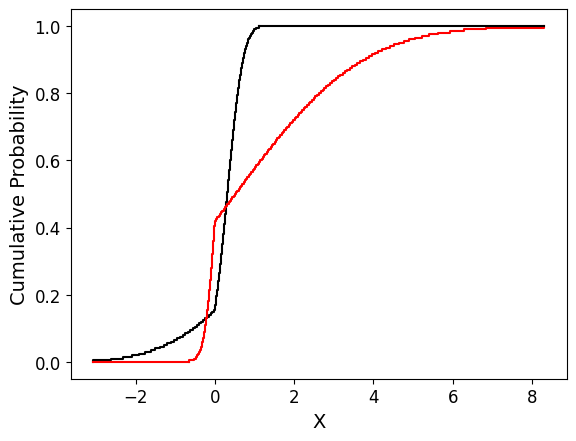

In [16]:

#plotPbox_bounds(res_ext.raw_data['bounds'][1])
plotPbox_bounds(var_ext.raw_data['bounds'][1])

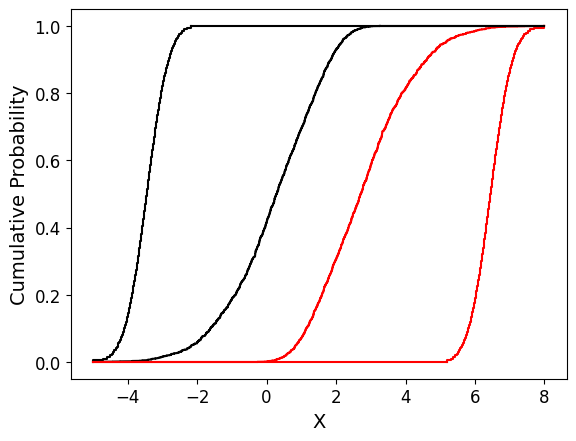

In [17]:
plotPbox_bounds(res_ext.raw_data['bounds'][0])
plotPbox_bounds(var_ext.raw_data['bounds'][0])

In [ ]:
res_end = focused_discretisation_propagation_method(x=x, f=Fun, method = 'endpoints', n_disc= 4)

In [ ]:
res_end_10 = focused_discretisation_propagation_method(x=x, f=Fun, method = 'endpoints', n_disc= 10)

In [ ]:
res_end_10_5 = focused_discretisation_propagation_method(x=x, f=Fun, method = 'endpoints', n_disc= 10, condensation = 5)

In [ ]:
plotPbox_bounds(res_end.raw_data['bounds'][1])
plotPbox_bounds(res_end_10.raw_data['bounds'][1])
plotPbox_bounds(res_end_10_5.raw_data['bounds'][1])

In [ ]:
res_end = focused_discretisation_propagation_method(x=x, f=Fun, method = 'endpoints', n_disc= 4)

In [ ]:
plotPbox_bounds(res_end.raw_data['bounds'][0])
plotPbox_bounds(res_ext.raw_data['bounds'][0])

In [19]:
import pandas as pd

def expand_dataframe(df, column_name):
    """
    Expands a DataFrame by splitting a column with comma-separated strings 
    into multiple rows, one string per row.

    Args:
        df: The input DataFrame.
        column_name: The name of the column to expand.

    Returns:
        A new DataFrame with the expanded column, or the original DataFrame
        if the specified column doesn't exist or doesn't contain strings.
        Returns an empty DataFrame if an error occurs during processing.
    """

    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return df  # Or raise an exception if you prefer

    try:
      # Check if the column contains string values (or mixed types that can be cast to string)
      if not pd.api.types.is_string_dtype(df[column_name]) and not all(isinstance(x, str) for x in df[column_name] if not pd.isna(x)): #Handle also potential mixed types
          try:
              df[column_name] = df[column_name].astype(str) # Try to convert to string
          except:
              print(f"Column '{column_name}' is not of string type or cannot be converted.")
              return df

      # Efficiently split and expand using explode (pandas >= 1.4.0)
      if pd.__version__ >= '1.4.0':
          new_df = df.assign(**{column_name: df[column_name].str.split(',')}).explode(column_name)
          new_df[column_name] = new_df[column_name].str.strip() # Remove extra spaces
          return new_df
      else:  # For older pandas versions
          new_rows = []
          for _, row in df.iterrows():
              values = row[column_name]
              if isinstance(values, str):  # Handle cases where the cell might be NaN or other non-string type
                  for value in values.split(','):
                      new_row = row.copy()
                      new_row[column_name] = value.strip() # Remove extra spaces
                      new_rows.append(new_row)
              else:
                  new_rows.append(row) # Keep original row if no string to split

          new_df = pd.DataFrame(new_rows)
          return new_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

# Example usage:
data = {'id': [1, 2, 3], 'tags': ['a, b, c', 'd', 'e, f']}
df = pd.DataFrame(data)

expanded_df = expand_dataframe(df, 'tags')
print(expanded_df)

data2 = {'id': [1, 2, 3], 'tags': ['a, b, c', 123, 'e, f']} #Mixed types
df2 = pd.DataFrame(data2)

expanded_df2 = expand_dataframe(df2, 'tags')
print(expanded_df2)

data3 = {'id': [1, 2, 3], 'tags': ['a, b, c', None, 'e, f']} #None values
df3 = pd.DataFrame(data3)

expanded_df3 = expand_dataframe(df3, 'tags')
print(expanded_df3)

data4 = {'id': [1, 2, 3], 'tags': ['a, b, c', 'd', 'e, f']}
df4 = pd.DataFrame(data4)
expanded_df4 = expand_dataframe(df4, 'tags') #Column not found
print(expanded_df4)

   id tags
0   1    a
0   1    b
0   1    c
1   2    d
2   3    e
2   3    f
   id tags
0   1    a
0   1    b
0   1    c
1   2  123
2   3    e
2   3    f
   id  tags
0   1     a
0   1     b
0   1     c
1   2  None
2   3     e
2   3     f
   id tags
0   1    a
0   1    b
0   1    c
1   2    d
2   3    e
2   3    f
